## This notebook outlines the following approximations made in the Syndat code:

    * Approximating the open count rate with smooth continuous function


In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import syndat
import nuctools
import os

Above we import all necessary python packages as well as the syndat package.

Note below that if you are running jupyter notebook not in VSCode, the matplotlib magic should be "%matplotlib notebook".

In [3]:
%matplotlib widget

### Run an initial experiment to import all the appropriate data

In [4]:
opendata = "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/rpi-open-ta181.csv"
sammy_xs = "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMMY.LST"

experiment = syndat.experiment(opendata, sammy_xs)

## Approximate the RRR open count rate

The following few sections of code, the open count rate spectrum from Brown, et al. is approximated with an exponential function. That function can then be used with the fitted parameters as a flexible approximation to the open count spectra that will allow for:
1. variable points in energy
2. no fixed notches messing with the transmission at certain energies
3. a flexible bin width

This approximation generates a smooth open count rate, therefore, before it can be used to generate data noise must be added in the following manner:

1. convert count rate to raw counts using a bin width and a number of triggers
2. Add poisson noise to the raw counts (ignoring monitor nornalization for this b/c the number of counts are large enough)
3. convert the noisy count data back to a count rate for use in the syndat methodology


[ 2212.70180199 -3365.55134779    23.88486286]


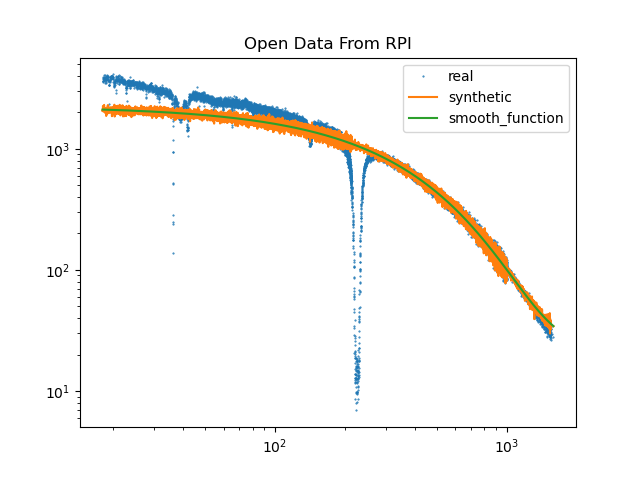

In [5]:
from scipy.optimize import curve_fit

# filter the RRR domain - split into two domains to get a better fit
RRR_domain = experiment.odat[(experiment.odat.tof>18)&(experiment.odat.tof<1600)].reset_index(drop=True)
fit_domain = experiment.odat[(experiment.odat.tof>275)&(experiment.odat.tof<1600)].reset_index(drop=True)

def func(x, a, b, c):
    return (a * np.exp(b * x*1e-6) + c) 

popt, pcov = curve_fit(func, fit_domain.tof, fit_domain.cps)
smoothed_cps = func(RRR_domain.tof, *popt)
smoothed_cts = smoothed_cps*RRR_domain.bw*experiment.redpar.val.trig 
noisy_cts = syndat.exp_effects.pois_noise(smoothed_cts)
noisy_cps = noisy_cts/RRR_domain.bw/experiment.redpar.val.trig 

figure()
title('Open Data From RPI')
plot(RRR_domain.tof, RRR_domain.cps, '.', ms=1, label="real")
plot(RRR_domain.tof, noisy_cps, label="synthetic")
plot(RRR_domain.tof, smoothed_cps, label="smooth_function")
xscale('log'); 
yscale('log')
legend()

print(popt)

In [6]:

E = syndat.exp_effects.t_to_e((experiment.odat.tof-experiment.redpar.val.t0)*1e-6, experiment.redpar.val.tof_dist, True)
tof = syndat.exp_effects.e_to_t(E,experiment.redpar.val.tof_dist, True)*1e6+experiment.redpar.val.t0
E

0        5.313697e+07
1        4.659825e+06
2        1.618690e+06
3        8.140801e+05
4        4.886650e+05
             ...     
16041    1.399729e+00
16042    1.333885e+00
16043    1.272579e+00
16044    1.215406e+00
16045    1.162000e+00
Name: tof, Length: 16046, dtype: float64

In [ ]:

# syndat.sammy_interface.write_estruct_file(E, '/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/estruct_rpi_open')

In [ ]:
# write estruct file for smooth open data
# syndat.sammy_interface.write_estruct_file(smoothed_odat.E, '/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/estruct_smoothopen')